In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [3]:
BATCH_SIZE = 512
RNN_HIDDEN_SIZE = 128

In [4]:
def model_fn(features, labels, mode):
    # input_layer = tf.reshape(features["x"], [-1, 784, 1])

    # rnn_cell = tf.nn.rnn_cell.LSTMCell(RNN_HIDDEN_SIZE)
    # initial_state = rnn_cell.zero_state(batch_size=BATCH_SIZE, dtype=tf.float32)
    # _, state = tf.nn.dynamic_rnn(rnn_cell, input_layer, initial_state=initial_state, dtype=tf.float32)
    
    # dense1 = tf.layers.dense(inputs=tf.reshape(state, [-1, RNN_HIDDEN_SIZE * 2]), units=512, activation=tf.nn.relu)
    # dense2 = tf.layers.dense(inputs=dense1, units=1024, activation=tf.nn.relu)
    
    input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])
    conv1 = tf.layers.conv2d(inputs=input_layer,
                             filters=32,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1,
                             filters=64,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    predictions = tf.layers.dense(inputs=dense, units=784)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.mean_squared_error(labels=labels, predictions=predictions)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {'distance': tf.metrics.mean_squared_error(labels=labels, predictions=predictions)}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
est = tf.estimator.Estimator(model_fn=model_fn, model_dir='pattern_memorization_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'pattern_memorization_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C8634C3FD0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
logging_hook = tf.train.LoggingTensorHook(tensors={}, at_end=True)

train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},
                                                    y=train_data,
                                                    batch_size=BATCH_SIZE,
                                                    num_epochs=None,
                                                    shuffle=True)
est.train(input_fn=train_input_fn, steps=2000, hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into pattern_memorization_model\model.ckpt.
INFO:tensorflow:loss = 0.10354628, step = 1
INFO:tensorflow:global_step/sec: 1.35332
INFO:tensorflow:loss = 0.019295743, step = 101 (73.895 sec)
INFO:tensorflow:global_step/sec: 1.34168
INFO:tensorflow:loss = 0.012266307, step = 201 (74.536 sec)
INFO:tensorflow:global_step/sec: 1.35405
INFO:tensorflow:loss = 0.009925769, step = 301 (73.848 sec)
INFO:tensorflow:global_step/sec: 1.35258
INFO:tensorflow:loss = 0.008789191, step = 401 (73.938 sec)
INFO:tensorflow:global_step/sec: 1.35551
INFO:tensorflow:loss = 0.007772667, step = 501 (73.768 sec)
INFO:tensorflow:global_step/sec: 1.31098
INFO:tensorflow:loss = 0.007206575, step = 601 (76.283 sec)
INFO:tensorflow:global_step/sec: 1.3112
INFO:tensorflow:loss = 0.006461023, step = 701 (76.262 sec)
INFO:tensorflow:global_step/sec: 1.31888
INFO:tensorflow:loss = 0.0060463473, step = 801 (75.831 sec)
INFO:tensorflow:Sav

In [6]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": eval_data},
                                                   y=eval_data,
                                                   num_epochs=1,
                                                   shuffle=False)
est.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Starting evaluation at 2018-02-21-00:53:52
INFO:tensorflow:Restoring parameters from pattern_memorization_model\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-02-21-00:53:58
INFO:tensorflow:Saving dict for global step 2000: distance = 0.0039646816, global_step = 2000, loss = 0.003966247


{'distance': 0.0039646816, 'global_step': 2000, 'loss': 0.003966247}

In [9]:
test_images = eval_data[np.random.choice(mnist.test.num_examples, 3)]
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test_images}, shuffle=False)
preds = list(est.predict(input_fn))

INFO:tensorflow:Restoring parameters from pattern_memorization_model\model.ckpt-2000


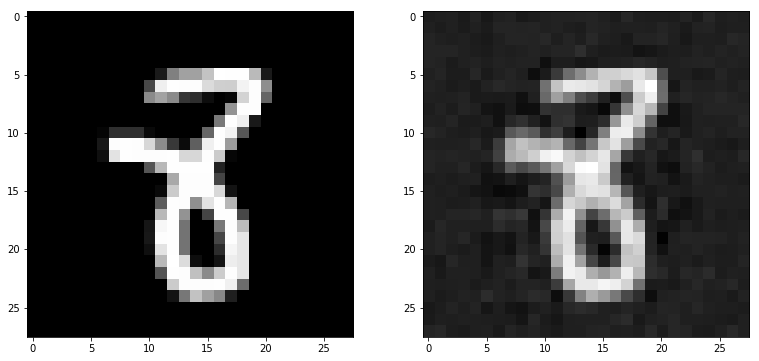

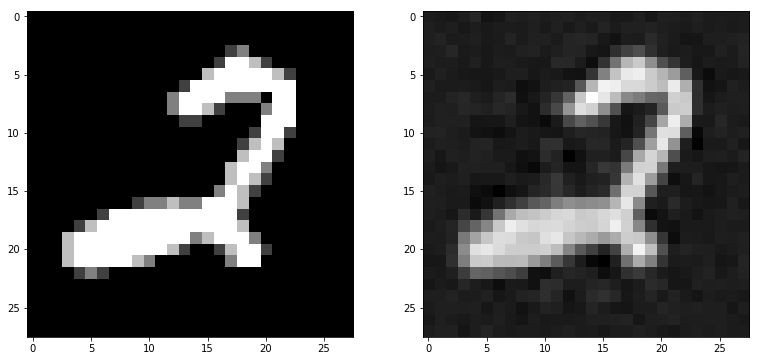

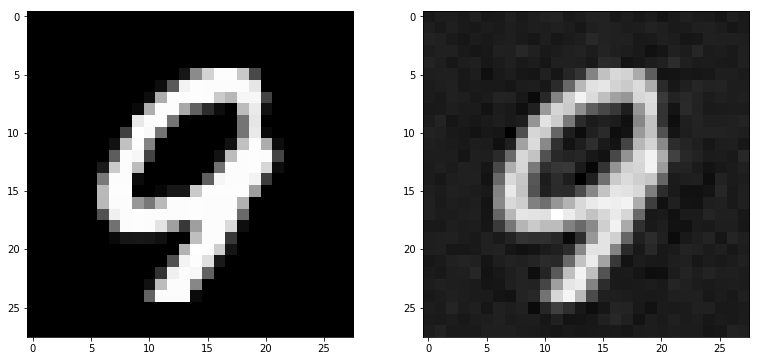

In [15]:
plt.rcParams["figure.figsize"] = [13, 6]

for i in range(3):
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(np.reshape(preds[i], [28, 28]), cmap='gray')
    plt.show()

# 끗